In [2]:
import tensorflow as tf
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt

RandomSeed = 1111
np.random.seed(RandomSeed)
tf.random.set_seed(RandomSeed)
# tf.set_random_seed(1111)

In [3]:
# 这里应该是时间区域0-1，空间区域0-0.5，0.6-1.1?
lb = np.array([0, 0])  # 区域左下角
ub = np.array([1, 1])  # 区域右上角

lb1 = np.array([ 0, 0])  # 子区域1左下角
ub1 = np.array([ 1/2, 1]) # 子区域1右上角

delta = 0.1  # 偏移量

lb2 = np.array([1/2 + delta, 0]) # 子区域2左下角
ub2 = np.array([ 1 + delta , 1]) # 子区域2右上角
# Nif 内部点的数量 Nb 边界点的数量 
Nif = 2000
Nb = 500

layers = [2, 32, 32, 1]
# 生成随机点的总数量
Total_Num_x = 5000

In [4]:
x_star_1 = np.random.rand(Total_Num_x, 1) * (ub1[0]-lb1[0]) + lb1[0]  # 子区域1x方向边界的随机点坐标
x_star_2 = np.random.rand(Total_Num_x, 1) * (ub2[0]-lb2[0]) + lb2[0]  # 子区域2x方向边界的随机点坐标
t_star = np.random.rand(Total_Num_x, 1) * (ub[1]-lb[1]) + lb[1]       # 整个区域边界t的随机时间点

# 不同边界条件下的点 六个边界，上下时间边界以及两个子区域内的左右边界

idx1 = np.random.choice(Total_Num_x, Nb, replace=False)  # 从(0,Total_Num_x)随机抽取Nb个数，不能重复
X_xlb = np.full((Nb,1), lb1[0])  # 坐标：子区域1的左边界坐标，维度（500，1）,充满左边界x坐标值
T_xlb = t_star[idx1,:] # 时间t坐标随机 

idx2 = np.random.choice(Total_Num_x, Nb, replace=False)
X_xub = np.full((Nb,1), ub2[0]) # 坐标：子区域2的右边界坐标，维度（500，1）,充满右边界x坐标值
T_xub = t_star[idx2,:] # 时间t坐标随机 

idx3 = np.random.choice(Total_Num_x, Nb, replace=False)
X_tlb_1 = x_star_1[idx3,:] # 抽取Nb个
T_tlb_1 = np.full((Nb,1), lb1[1]) # 子区域1的下边界坐标充满，即子区域1的初始条件

idx4 = np.random.choice(Total_Num_x, Nb, replace=False)
X_tlb_2 = x_star_2[idx4,:] # 抽取Nb个
T_tlb_2 = np.full((Nb,1), lb1[1]) # 子区域2的下边界坐标充满，即子区域1的初始条件

idx5 = np.random.choice(Total_Num_x, Nb, replace=False)
X_tub_1 = x_star_1[idx5,:]
T_tub_1 = np.full((Nb,1), ub1[1]) # 上坐标

idx6 = np.random.choice(Total_Num_x, Nb, replace=False)
X_tub_2 = x_star_2[idx6,:]
T_tub_2 = np.full((Nb,1), ub1[1])

In [5]:
# 组合边界点(x,t)
# 子区域 1
x_train_1 = np.concatenate((X_xlb,X_tlb_1,X_tub_1))  # 左下上边界的x值
t_train_1 = np.concatenate((T_xlb,T_tlb_1,T_tub_1)) # 左下上边界的t值
X_train_1 = np.concatenate([x_train_1, t_train_1], 1) # 组合成一个坐标
# 子区域 2
x_train_2 = np.concatenate((X_xub,X_tlb_2,X_tub_2))
t_train_2 = np.concatenate((T_xub,T_tlb_2,T_tub_2))
X_train_2 = np.concatenate([x_train_2, t_train_2], 1)

In [6]:
def Exact_solution1(X):
    u = (X[:,0:1]**2+10)*(X[:,1:2]-X[:,1:2]**2)
    return u

def Exact_solution2(X):
    u = (5*(X[:,0:1]-delta)**2+9)*(X[:,1:2]-X[:,1:2]**2)
    return u

In [7]:
u_train_1 = Exact_solution1(X_train_1) # 带入得到子区域1边界的精确解
u_train_2 = Exact_solution2(X_train_2) # 带入得到子区域2边界的精确解

In [8]:
X_train = np.concatenate([X_train_1,X_train_2])  # 拼接两个域的训练点坐标x,t
u_train = np.concatenate([u_train_1,u_train_2])  # 拼接两个域的训练点坐标x,t对应的精确解

In [9]:
P = np.concatenate([X_train,u_train],1) # 拼接（坐标(x,t)，精确值）
np.random.shuffle(P)  # 打乱顺序
X_train_shuffle = P[:,0:2] # 坐标
u_train_shuffle = P[:,2:3] # 对应值

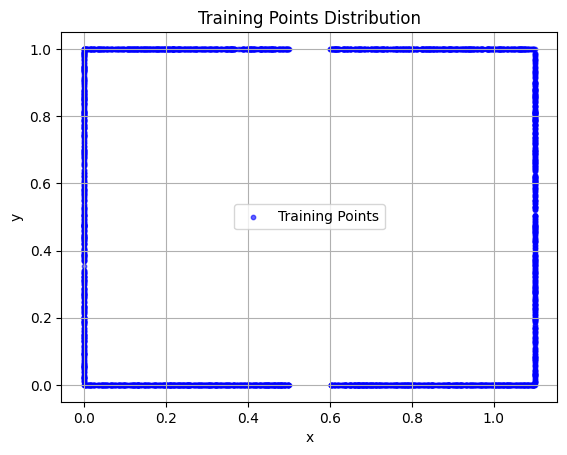

In [10]:
def plot_training_points(X_train):
    plt.figure()
    plt.scatter(X_train[:,0],X_train[:,1],s=10,color='blue',alpha=0.6,label='Training Points')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Training Points Distribution')
    plt.grid()
    plt.show()

plot_training_points(X_train)  # 那么这里都是边界上的解

In [50]:
class PtPINN:
    def __init__(self, X, u, lb, ub, lb1, ub1, lb2, ub2, layers, delta):
        self.lb = lb
        self.ub = ub
        self.lb1 = lb1
        self.ub1 = ub1
        self.lb2 = lb2
        self.ub2 = ub2
        self.layers = layers
        self.delta = delta

        self.weights, self.biases = self.initialize_NN(layers)
        self.optimizer_Adam = tf.keras.optimizers.Adam(0.001)

        self.x = X[:, 0:1]
        self.y = X[:, 1:2]
        self.u = u

        self.x_tf = tf.convert_to_tensor(self.x, dtype=tf.float32)
        self.y_tf = tf.convert_to_tensor(self.y, dtype=tf.float32)
        self.u_tf = tf.convert_to_tensor(self.u, dtype=tf.float32)

        # Compute predictions and losses
        self.u_pred, _, _, _, _ = self.net_u(self.x_tf, self.y_tf)
        self.lossS = tf.reduce_mean(tf.square(self.u_tf - self.u_pred))

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_u(self, x, y):
        X = tf.concat([x, y], 1)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X)
            tape.watch(x)
            tape.watch(y)
            u = self.neural_net(X, self.weights, self.biases)
            u_x = tape.gradient(u, x)
            u_y = tape.gradient(u, y)
        print("output u:",u)
        print("output x:",x)
        print("output y:",y)
        print("output u_x:",u_x)
        print("output u_y:",u_y)
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)
        del tape
        return u, u_x, u_y, u_xx, u_yy

    def net_f1(self, x, y):
        u, u_x, u_y, u_xx, u_yy = self.net_u(x, y)
        Q = 10 * (10 + x ** 2) - 10 * (y - y ** 2)
        f_u = 5 * (-u_yy - u_xx) - Q
        return f_u, Q

    def net_f2(self, x, y):
        u, u_x, u_y, u_xx, u_yy = self.net_u(x, y)
        Q = 2 * (9 + 5 * (x - self.delta) ** 2) - 10 * (y - y ** 2)
        f_u = -u_yy - u_xx - Q
        return f_u, Q

    @tf.function
    def train_step(self, x_tf, y_tf, u_tf, x_f1_tf, y_f1_tf, x_f2_tf, y_f2_tf, x_if_1_tf, x_if_2_tf, y_if_tf):
        with tf.GradientTape() as tape:
            u_pred, _, _, _, _ = self.net_u(x_tf, y_tf)
            lossS = tf.reduce_mean(tf.square(u_tf - u_pred))

            u1_if_pred, u1x_if_pred, _, _, _ = self.net_u(x_if_1_tf, y_if_tf)
            u2_if_pred, u2x_if_pred, _, _, _ = self.net_u(x_if_2_tf, y_if_tf)

            loss_uc = tf.reduce_mean(tf.square(u1_if_pred - u2_if_pred))
            loss_fc = tf.reduce_mean(tf.square(5 * u1x_if_pred - u2x_if_pred))

            f1_pred, Q1_pred = self.net_f1(x_f1_tf, y_f1_tf)
            f2_pred, Q2_pred = self.net_f2(x_f2_tf, y_f2_tf)

            lossfu = tf.reduce_sum(tf.square(f1_pred)) / tf.reduce_sum(tf.square(Q1_pred)) + tf.reduce_sum(tf.square(f2_pred)) / tf.reduce_sum(tf.square(Q2_pred))

            loss = lossS + lossfu + loss_uc + loss_fc

        grads = tape.gradient(loss, self.weights + self.biases)
        self.optimizer_Adam.apply_gradients(zip(grads, self.weights + self.biases))
        return loss, lossS, lossfu, loss_fc, loss_uc

    def train(self, nIter, Nf, Nb, Nif):
        # 生成边界,界面,域内的训练点
        X_train1 = self.lb1 + (self.ub1 - self.lb1) * lhs(2, Nf)
        self.xtrain_f1 = tf.convert_to_tensor(X_train1[:, 0:1], dtype=tf.float32)
        self.ytrain_f1 = tf.convert_to_tensor(X_train1[:, 1:2], dtype=tf.float32)

        X_train2 = self.lb2 + (self.ub2 - self.lb2) * lhs(2, Nf)
        self.xtrain_f2 = tf.convert_to_tensor(X_train2[:, 0:1], dtype=tf.float32)
        self.ytrain_f2 = tf.convert_to_tensor(X_train2[:, 1:2], dtype=tf.float32)

        X1_if_train = np.hstack(([self.ub1[0], self.lb1[1]] + [0, self.ub1[1] - self.lb1[1]] * lhs(2, Nif)))
        self.trainx_if_1 = tf.convert_to_tensor(X1_if_train[:, 0:1], dtype=tf.float32)
        self.trainy_if = tf.convert_to_tensor(X1_if_train[:, 1:2], dtype=tf.float32)

        X2_if_train = self.lb2 + [0, self.ub2[1] - self.lb2[1]] * lhs(2, Nif)
        self.trainx_if_2 = tf.convert_to_tensor(X2_if_train[:, 0:1], dtype=tf.float32)

        X_lb2_train = self.lb2 + [0, self.ub2[1] - self.lb2[1]] * lhs(2, Nb)
        self.xtrain_lb2 = tf.convert_to_tensor(X_lb2_train[:, 0:1], dtype=tf.float32)
        self.ytrain_b2 = tf.convert_to_tensor(X_lb2_train[:, 1:2], dtype=tf.float32)

        X_rb2_train = np.hstack(([self.ub2[0], self.lb2[1]] + [0, self.ub2[1] - self.lb2[1]] * lhs(2, Nb)))
        self.xtrain_rb2 = tf.convert_to_tensor(X_rb2_train[:, 0:1], dtype=tf.float32)
        self.ytrain_b2 = tf.convert_to_tensor(X_rb2_train[:, 1:2], dtype=tf.float32)

        for it in range(nIter):
            loss, lossS, lossfu, loss_fc, loss_uc = self.train_step(self.x_tf, self.y_tf, self.u_tf,
                                                                    self.xtrain_f1, self.ytrain_f1,
                                                                    self.xtrain_f2, self.ytrain_f2,
                                                                    self.trainx_if_1, self.trainx_if_2, self.trainy_if)
            if it % 10 == 0:
                self.callback(loss, lossS, lossfu, loss_fc, loss_uc)

In [51]:
model = PtPINN(X_train_shuffle, u_train_shuffle, lb, ub, lb1, ub1, lb2, ub2, layers, delta)

output u: tf.Tensor(
[[ 0.16503526]
 [ 0.1963538 ]
 [ 0.19116758]
 ...
 [-0.09119096]
 [-0.07200328]
 [ 0.04107996]], shape=(3000, 1), dtype=float32)
output x: tf.Tensor(
[[0.9885749 ]
 [0.61323506]
 [0.        ]
 ...
 [0.97995585]
 [0.7936814 ]
 [0.        ]], shape=(3000, 1), dtype=float32)
output y: tf.Tensor(
[[1.        ]
 [1.        ]
 [0.7346655 ]
 ...
 [0.        ]
 [0.        ]
 [0.14045107]], shape=(3000, 1), dtype=float32)
output u_x: None
output u_y: None


TypeError: Argument `target` should be a list or nested structure of Tensors, Variables or CompositeTensors to be differentiated, but received None.

# kerse

In [11]:
import tensorflow as tf
import numpy as np
from pyDOE import lhs

RandomSeed = 1111
np.random.seed(RandomSeed)
tf.random.set_seed(RandomSeed)

class PtPINN:
    def __init__(self, X, u, lb, ub, lb1, ub1, lb2, ub2, layers, delta):
        self.X = tf.cast(X, tf.float32)
        self.x = tf.cast(X[:, 0:1], tf.float32)
        self.y = tf.cast(X[:, 1:2], tf.float32)
        self.u = tf.cast(u, tf.float32)
        self.lb = tf.cast(lb, tf.float32)
        self.ub = tf.cast(ub, tf.float32)
        self.lb1 = tf.cast(lb1, tf.float32)
        self.ub1 = tf.cast(ub1, tf.float32)
        self.lb2 = tf.cast(lb2, tf.float32)
        self.ub2 = tf.cast(ub2, tf.float32)
        self.delta = tf.cast(delta, tf.float32)

        # Initialize NNs
        self.layers = layers
        self.model = self.build_model(layers)
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    def build_model(self, layers):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        for width in layers[1:-1]:
            model.add(tf.keras.layers.Dense(width, activation='tanh'))
        model.add(tf.keras.layers.Dense(layers[-1]))
        return model
    
    def net_u(self, x, y):
        X = tf.concat([x, y], 1)
        u = self.model(X)
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        return u, u_x, u_y, u_xx, u_yy

    @tf.function
    def train_step(self, x, y, u):
        with tf.GradientTape(persistent=True) as tape:
            u_pred, u_x, u_y, u_xx, u_yy = self.net_u(x, y)
            loss = tf.reduce_mean(tf.square(u - u_pred))
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss

    def train(self, nIter):
        for it in range(nIter):
            loss = self.train_step(self.x, self.y, self.u)
            if it % 10 == 0:
                print(f'It: {it}, Loss: {loss.numpy():.6e}')

    def predict(self, x, y):
        X = tf.concat([x, y], 1)
        u_pred = self.model(X)
        return u_pred

In [64]:
if __name__ == "__main__":
    lb = np.array([0, 0], dtype=np.float32)
    ub = np.array([1, 1], dtype=np.float32)
    lb1 = np.array([0, 0], dtype=np.float32)
    ub1 = np.array([1/2, 1], dtype=np.float32)
    delta = 0.1
    lb2 = np.array([1/2 + delta, 0], dtype=np.float32)
    ub2 = np.array([1 + delta, 1], dtype=np.float32)
    Nif = 2000
    Nb = 500
    layers = [2, 50, 50, 50, 50, 50, 1]
    Total_Num_x = 5000

    x_star_1 = np.random.rand(Total_Num_x, 1).astype(np.float32) * (ub1[0]-lb1[0]) + lb1[0]
    x_star_2 = np.random.rand(Total_Num_x, 1).astype(np.float32) * (ub2[0]-lb2[0]) + lb2[0]
    t_star = np.random.rand(Total_Num_x, 1).astype(np.float32) * (ub[1]-lb[1]) + lb[1]

    idx1 = np.random.choice(Total_Num_x, Nb, replace=False)
    X_xlb = np.full((Nb,1), lb1[0], dtype=np.float32)
    T_xlb = t_star[idx1,:]

    idx2 = np.random.choice(Total_Num_x, Nb, replace=False)
    X_xub = np.full((Nb,1), ub2[0], dtype=np.float32)
    T_xub = t_star[idx2,:]

    idx3 = np.random.choice(Total_Num_x, Nb, replace=False)
    X_tlb_1 = x_star_1[idx3,:]
    T_tlb_1 = np.full((Nb,1), lb1[1], dtype=np.float32)

    idx4 = np.random.choice(Total_Num_x, Nb, replace=False)
    X_tlb_2 = x_star_2[idx4,:]
    T_tlb_2 = np.full((Nb,1), lb1[1], dtype=np.float32)

    idx5 = np.random.choice(Total_Num_x, Nb, replace=False)
    X_tub_1 = x_star_1[idx5,:]
    T_tub_1 = np.full((Nb,1), ub1[1], dtype=np.float32)

    idx6 = np.random.choice(Total_Num_x, Nb, replace=False)
    X_tub_2 = x_star_2[idx6,:]
    T_tub_2 = np.full((Nb,1), ub1[1], dtype=np.float32)

    x_train_1 = np.concatenate((X_xlb,X_tlb_1,X_tub_1))
    t_train_1 = np.concatenate((T_xlb,T_tlb_1,T_tub_1))
    X_train_1 = np.concatenate([x_train_1, t_train_1], 1)

    x_train_2 = np.concatenate((X_xub,X_tlb_2,X_tub_2))
    t_train_2 = np.concatenate((T_xub,T_tlb_2,T_tub_2))
    X_train_2 = np.concatenate([x_train_2, t_train_2], 1)

    def Exact_solution1(X):
        u = (X[:,0:1]**2+10)*(X[:,1:2]-X[:,1:2]**2)
        return u

    def Exact_solution2(X):
        u = (5*(X[:,0:1]-delta)**2+9)*(X[:,1:2]-X[:,1:2]**2)
        return u

    u_train_1 = Exact_solution1(X_train_1)
    u_train_2 = Exact_solution2(X_train_2)

    X_train = np.concatenate([X_train_1,X_train_2])
    u_train = np.concatenate([u_train_1,u_train_2])

    P = np.concatenate([X_train,u_train],1)
    np.random.shuffle(P)
    X_train_shuffle = P[:,0:2]
    u_train_shuffle = P[:,2:3]

    model = PtPINN(X_train_shuffle, u_train_shuffle, lb, ub, lb1, ub1, lb2, ub2, layers, delta)
    Nf = 5000
    model.train(2000)

    x = np.linspace(lb[0], ub[0], 100).reshape(100,1).astype(np.float32)
    y = np.linspace(lb[1], ub[1], 100).reshape(100,1).astype(np.float32)

    def Exact_solution(x,y):
        if x<=1/2:
            u = (x**2+10)*(y-y**2)
        else:
            u = (5*x**2+9)*(y-y**2)
        return u

    X, Y = np.meshgrid(x,y)
    X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

    u_star = X_star[:,0:1]
    for i in range(len(X_star[:,0:1])):
        u_star[i] = Exact_solution(X_star[i,0:1],X_star[i,1:2])

    for i in range(len(x)):
        if x[i]>1/2:
            x[i] = x[i] + delta

    X, Y = np.meshgrid(x,y)
    X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
    u_pred = model.predict(X_star[:,0:1],X_star[:,1:2]).numpy()
    
    erroru =  np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    print(f'random seed: {RandomSeed}')
    print(f'delta: {delta:.3e}')
    print(f'Error2 u: {erroru:.6e}')

It: 0, Loss: 1.510268e+00
It: 10, Loss: 1.190253e+00
It: 20, Loss: 1.142370e+00
It: 30, Loss: 1.050027e+00
It: 40, Loss: 8.435853e-01
It: 50, Loss: 5.195269e-01
It: 60, Loss: 2.707382e-01
It: 70, Loss: 1.473683e-01
It: 80, Loss: 7.980801e-02
It: 90, Loss: 4.970159e-02
It: 100, Loss: 3.806803e-02
It: 110, Loss: 2.998201e-02
It: 120, Loss: 2.638172e-02
It: 130, Loss: 2.440587e-02
It: 140, Loss: 2.263120e-02
It: 150, Loss: 2.117065e-02
It: 160, Loss: 1.990178e-02
It: 170, Loss: 1.913701e-02
It: 180, Loss: 1.823531e-02
It: 190, Loss: 1.726521e-02
It: 200, Loss: 1.667278e-02
It: 210, Loss: 1.514830e-02
It: 220, Loss: 1.476745e-02
It: 230, Loss: 1.352608e-02
It: 240, Loss: 1.537947e-02
It: 250, Loss: 1.211985e-02
It: 260, Loss: 1.152901e-02
It: 270, Loss: 1.104241e-02
It: 280, Loss: 1.028265e-02
It: 290, Loss: 1.034501e-02
It: 300, Loss: 1.094260e-02
It: 310, Loss: 9.026403e-03
It: 320, Loss: 8.132486e-03
It: 330, Loss: 7.667099e-03
It: 340, Loss: 7.077362e-03
It: 350, Loss: 6.871537e-03
It:

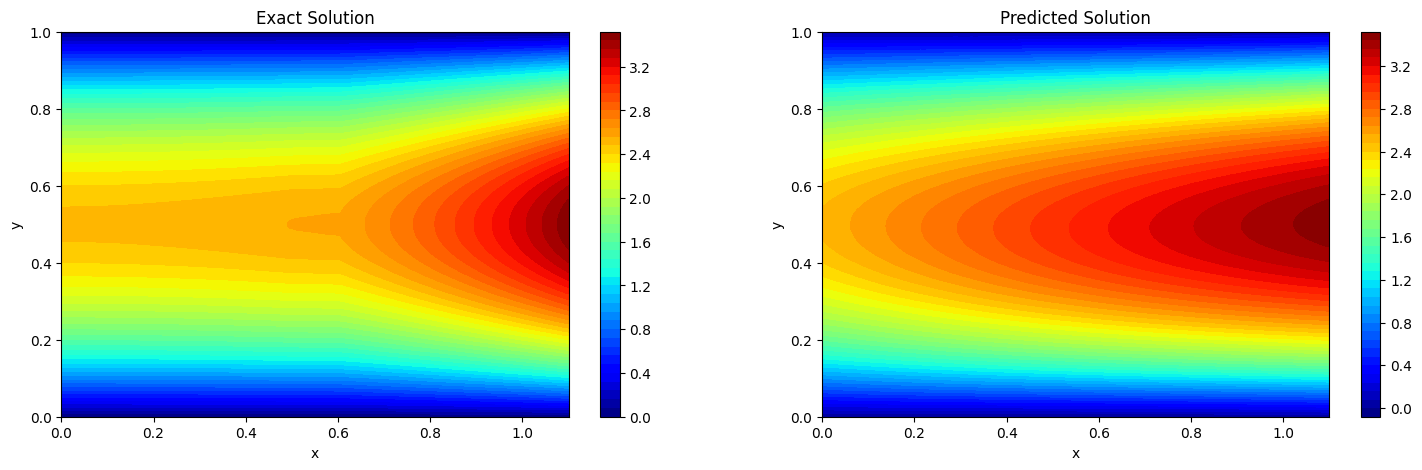

In [65]:
import matplotlib.pyplot as plt
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Exact solution plot
c = ax[0].contourf(X, Y, u_star.reshape(100, 100), levels=50, cmap='jet')
fig.colorbar(c, ax=ax[0])
ax[0].set_title('Exact Solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

# Predicted solution plot
c = ax[1].contourf(X, Y, u_pred.reshape(100, 100), levels=50, cmap='jet')
fig.colorbar(c, ax=ax[1])
ax[1].set_title('Predicted Solution')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

plt.show()

In [60]:
x = np.linspace(lb[0], ub[0], 100).reshape(100,1).astype(np.float32)
y = np.linspace(lb[1], ub[1], 100).reshape(100,1).astype(np.float32)

def Exact_solution(x,y):
    if x<=1/2:
        u = (x**2+10)*(y-y**2)
    else:
        u = (5*x**2+9)*(y-y**2)
    return u

X, Y = np.meshgrid(x,y)
X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

u_star = X_star[:,0:1]
for i in range(len(X_star[:,0:1])):
    u_star[i] = Exact_solution(X_star[i,0:1],X_star[i,1:2])

for i in range(len(x)):
    if x[i]>1/2:
        x[i] = x[i] + delta

X, Y = np.meshgrid(x,y)
X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_pred = model.predict(X_star[:,0:1],X_star[:,1:2]).numpy()

In [61]:
for i in range(len(x)):
    if x[i]>1/2:
        x[i] = x[i] - delta
X, Y = np.meshgrid(x,y)
X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

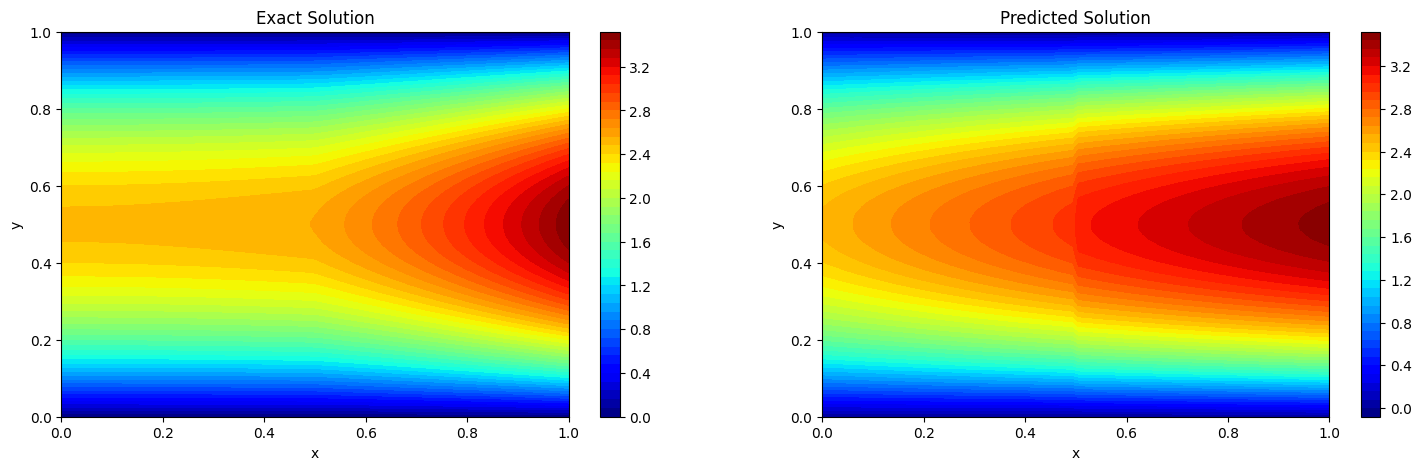

In [62]:
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Exact solution plot
c = ax[0].contourf(X, Y, u_star.reshape(100, 100), levels=50, cmap='jet')
fig.colorbar(c, ax=ax[0])
ax[0].set_title('Exact Solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

# Predicted solution plot
c = ax[1].contourf(X, Y, u_pred.reshape(100, 100), levels=50, cmap='jet')
fig.colorbar(c, ax=ax[1])
ax[1].set_title('Predicted Solution')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

plt.show()